# ISML - Assignment03

Data is a subsampled version of the MNIST dataset. It contains images for 10 digits (10 classes). The dataset contains 6,000 samples. The images from the data set have the size 28 x 28. They are saved in the csv data files. Every line of these files consists of an image, i.e. 785 numbers between 0 and 1. The first number of each line is the label, i.e. the digit which is depicted in the image. The following 784 numbers are the pixels of the 28 x 28 image.

### Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('~/Documents/mnist.csv', header=None)

# Rename the first column as 'label' and the rest as 'pixel_1', 'pixel_2', ..., 'pixel_784'
column_names = ['label'] + [f'pixel_{i}' for i in range(1, 785)]
df.columns = column_names

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 785 entries, label to pixel_784
dtypes: float64(785)
memory usage: 35.9 MB


In [3]:
y = df.iloc[:, :1]
X = df.iloc[:, 1:]
k=10

## Question 01

Perform PCA on the dataset to reduce each sample into a 10-dimensional feature vector. Show the covariance matrix of the transformed data. Please also copy your code snippet here. 

### Results with Custom Implementation

In [4]:
class customPCA:
    def __init__(self, x, n_components=None):
        self.x = x
        self.n_components = n_components
        self.num_samples, self.num_features = x.shape
        self.cov_mat = None
        self.P = None
        self.y = None

    def cov(self):
        self.cov_mat = np.cov(self.x.T)
        return self.cov_mat
    
    def standardization(self):
        return self.x - np.mean(self.x, axis=0)  # Mean centering the data
    
    def reduce_feature(self):
        x_meaned = self.standardization()  # Step 1: Mean centering the data
        x_cov = self.cov()  # Step 2: Compute covariance matrix
        eigen_val, eigen_vec = np.linalg.eig(x_cov)  # Step 3: Eigen decomposition
        
        # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
        sort_index = np.argsort(eigen_val)[::-1]  # Sort in descending order
        sorted_eigenval = eigen_val[sort_index]
        sorted_eigenvector = eigen_vec[:, sort_index]
        
        # Select the top `n_components` eigenvectors
        self.P = sorted_eigenvector[:, :self.n_components]
        
        # Step 5: Transform the data using the selected principal components
        self.y = np.dot(x_meaned, self.P)
        return self.y

In [5]:
# Perform PCA to reduce to 10 dimensions
pca1 = customPCA(X, n_components=k) # Custom implementation
transformed_pca1 = pca1.reduce_feature()

print(f'Using custom PCA:')
print(f'The input x has shape {X.shape}, and the transformed X has shape {transformed_pca1.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(pca1.cov_mat), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_pca1.T)).real, 5)}.')

Using custom PCA:
The input x has shape (6000, 784), and the transformed X has shape (6000, 10)
The sum of the input covariance matrix is 1127.90333.
The sum of the transformed covariance matrix is 26.22057.


### Results with Scikit-Learn

In [6]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=10)
transformed_pca2 = pca2.fit_transform(X)

print(f'\nUsing scikit-learn PCA:')
print(f'The input X has shape {X.shape}, and the transformed X has shape {transformed_pca2.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(np.cov(X.T)), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_pca2.T)), 5)}.')


Using scikit-learn PCA:
The input X has shape (6000, 784), and the transformed X has shape (6000, 10)
The sum of the input covariance matrix is 1127.90333.
The sum of the transformed covariance matrix is 26.22056.


## Question 02

Perform k-means clustering to cluster the dataset (without applying PCA) into 10 groups.

In [7]:
# Initialize loss outside the function
loss = []

def k_means(x, k = 2 , epochs = 600):
    # 1. Randomly initialize k centroids
    np.random.seed(200)
    # "you need to randomly initialize k centroids using x"
    cluster_center = x[np.random.choice(x.shape[0], k, replace=False), :]

    clusters = [[] for _ in range(k)]

    # 2. Training
    for _ in range(epochs):
        new_clusters_center = np.zeros((k, x.shape[1]))

        # Reset clusters
        for i in range(k):
            clusters[i]=[] # Clear previous cluster assignments

        ## Calculate the distance from all points to the k cluster centers
        for i in range(x.shape[0]):
            xi = x[i]

            # "Calculate the distance of xi with each centroid using norm2"
            distances = np.linalg.norm(cluster_center - xi, axis = 1)

            # Assign points to the closest cluster. Returns the index of the nearest centriod to this datapoint
            c = np.argmin(distances)
            clusters[c].append(i) # Append this datapoint to this cluster

        ## b. M-step: recalculate the location of the centroid using the mean of the clusters
        for i in range(k):
            if len(clusters[i]) > 0:
                new_clusters_center[i] = np.mean(x[clusters[i]], axis=0)
            else:
                new_clusters_center[i] = x[np.random.randint(0, x.shape[0])]

        # c. If the centroid did not change, the algorithm should be stopped, otherwise continue.
        if np.all(new_clusters_center == cluster_center):
            return clusters, new_clusters_center

        # d. update the centroid
        loss.append(abs(np.sum(new_clusters_center - cluster_center)))
        cluster_center = new_clusters_center

    return clusters, cluster_center

In [8]:
clusters, cluster_center = k_means(X.values, 10)

for i in range(len(cluster_center)):
    print(f"Sum of cluster_center[{i}]:\t{round(np.sum(cluster_center[i]),5)}")

Sum of cluster_center[0]:	64.4931
Sum of cluster_center[1]:	96.311
Sum of cluster_center[2]:	122.48652
Sum of cluster_center[3]:	121.11269
Sum of cluster_center[4]:	146.85025
Sum of cluster_center[5]:	88.77067
Sum of cluster_center[6]:	112.2306
Sum of cluster_center[7]:	113.2068
Sum of cluster_center[8]:	128.77225
Sum of cluster_center[9]:	95.16095


## Question 03

Please plot the loss curve, that is, the change of loss value of the k-means algorithm with respect to the number of iterations.

In [9]:
# Method to plot the loss curve
def lossPlot(loss):
    plt.plot(range(len(loss)), loss, marker='o', label="Loss")
    plt.title("Loss Curve for K-Means")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Change in Centroid Positions)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

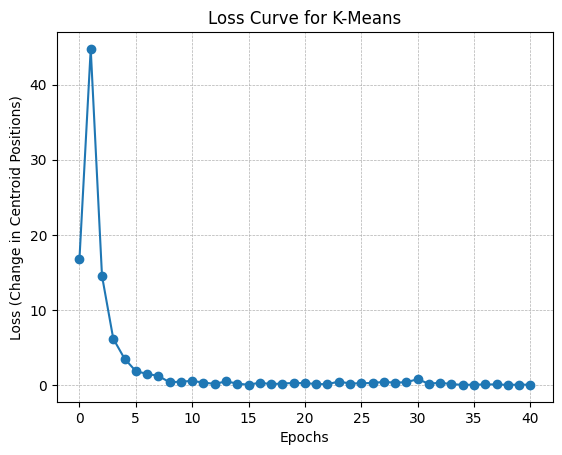

In [10]:
# Plot the loss curve after running k-means
lossPlot(loss)

## Question 04

Please use the ***first 4000 samples*** as the **training set** and ***remaining 2000 samples*** as the **validation set**, and design a way to choose the **best k** in k-means algorithm.

In [11]:
# Training set
X_train = X.values[:4000]
y_train = y.values[:4000]

# Testing set
X_test = X.values[4000:]
y_test = y.values[4000:]

# Range of k values to test
K = range(2,11)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (4000, 784)
Testing set shape: (2000, 784)


### Elbow Method

In [12]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions_train = [] # The average of the squared euclidian distances from cluster centers of respective clusters
inertias_train = [] # Sum of the squared distances of samples to their closest cluster center.
mapping1_train = {}
mapping2_train = {}

for k in K:
    clusters, cluster_centers = k_means(X_train, k)

    distortion = sum(np.min(cdist(X_train, cluster_centers, 'euclidean'), axis = 1)) / X_train.shape[0]
    distortions_train.append(distortion)

    inertia = sum(np.min(cdist(X_train, cluster_centers, 'euclidean')**2, axis = 1))
    inertias_train.append(inertia)

    mapping1_train[k] =  distortion
    mapping2_train[k] = inertia

    print(f"K = {k}")
    print(f"Training distortion:\t{distortion}")
    print(f"Training inertia:\t{inertia}")
    print("------------------------------------------")

print("\n==========================================\n")

distortions_test = [] # The average of the squared euclidian distances from cluster centers of respective clusters
inertias_test = [] # Sum of the squared distances of samples to their closest cluster center.
mapping1_test = {}
mapping2_test = {}

for k in K:
    clusters, cluster_centers = k_means(X_test, k)

    distortion = sum(np.min(cdist(X_test, cluster_centers, 'euclidean'), axis = 1)) / X_test.shape[0]
    distortions_test.append(distortion)

    inertia = sum(np.min(cdist(X_test, cluster_centers, 'euclidean')**2, axis = 1))
    inertias_test.append(inertia)

    mapping1_test[k] =  distortion
    mapping2_test[k] = inertia

    print(f"K = {k}")
    print(f"Test distortion:\t{distortion}")
    print(f"Test inertia:\t{inertia}")
    print("------------------------------------------")

K = 2
Training distortion:	6.916498314938021
Training inertia:	195003.72964848013
------------------------------------------
K = 3
Training distortion:	6.717256198218001
Training inertia:	184976.66375780667
------------------------------------------
K = 4
Training distortion:	6.578557353572085
Training inertia:	177344.03478958795
------------------------------------------
K = 5
Training distortion:	6.45448393776324
Training inertia:	170559.62026141208
------------------------------------------
K = 6
Training distortion:	6.350862373026768
Training inertia:	165588.65823967956
------------------------------------------
K = 7
Training distortion:	6.281296512618882
Training inertia:	161981.73435995224
------------------------------------------
K = 8
Training distortion:	6.202160169998884
Training inertia:	158872.7351398898
------------------------------------------
K = 9
Training distortion:	6.135590979897855
Training inertia:	155681.3684841936
------------------------------------------
K =

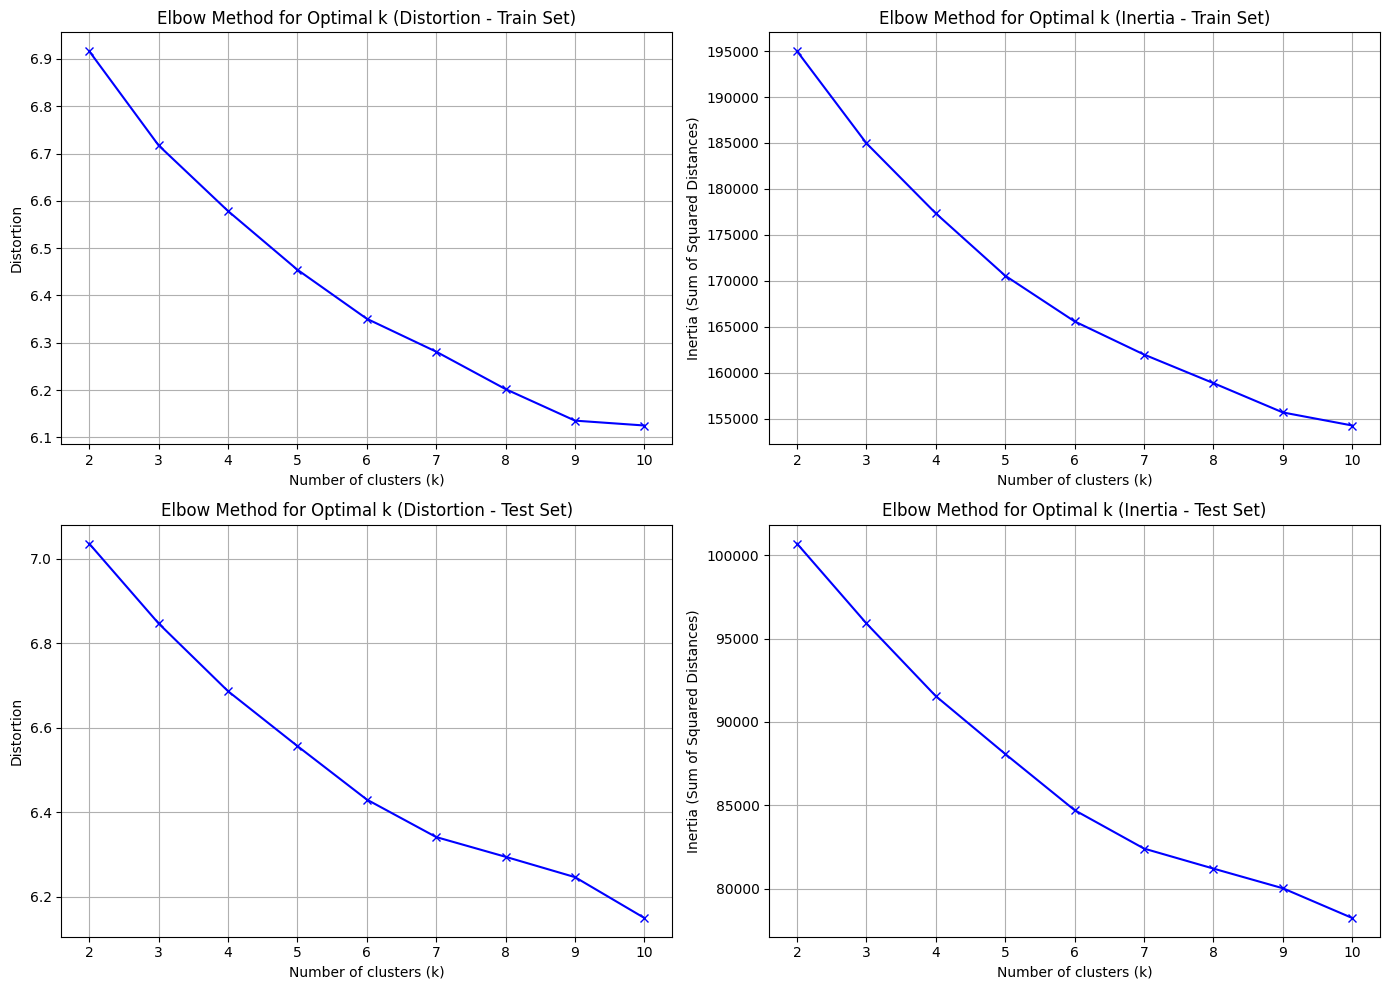

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot distortions of Train
axs[0, 0].plot(K, distortions_train, 'bx-')
axs[0, 0].set_xlabel('Number of clusters (k)')
axs[0, 0].set_ylabel('Distortion')
axs[0, 0].set_title('Elbow Method for Optimal k (Distortion - Train Set)')
axs[0, 0].grid(True)

# Plot inertia of Train
axs[0, 1].plot(K, inertias_train, 'bx-')
axs[0, 1].set_xlabel('Number of clusters (k)')
axs[0, 1].set_ylabel('Inertia (Sum of Squared Distances)')
axs[0, 1].set_title('Elbow Method for Optimal k (Inertia - Train Set)')
axs[0, 1].grid(True)

# Plot distortions of Test
axs[1, 0].plot(K, distortions_test, 'bx-')
axs[1, 0].set_xlabel('Number of clusters (k)')
axs[1, 0].set_ylabel('Distortion')
axs[1, 0].set_title('Elbow Method for Optimal k (Distortion - Test Set)')
axs[1, 0].grid(True)

# Plot inertia of Test
axs[1, 1].plot(K, inertias_test, 'bx-')
axs[1, 1].set_xlabel('Number of clusters (k)')
axs[1, 1].set_ylabel('Inertia (Sum of Squared Distances)')
axs[1, 1].set_title('Elbow Method for Optimal k (Inertia - Test Set)')
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Silhouette Method

In [14]:
from sklearn.metrics import silhouette_score
silhouette_scores_train = []

# Loop over different k values
for k in K:
    # Perform k-means clustering on the training set
    clusters, cluster_centers = k_means(X_train, k)
    
    # Convert clusters to labels
    labels = np.zeros(X_train.shape[0], dtype=int)
    
    for cluster_index, cluster in enumerate(clusters):
        # Assign the cluster index to each point in the cluster
        for data_index in cluster:
            labels[data_index] = cluster_index

    # Calculate the silhouette score
    score = silhouette_score(X_train, labels)
    silhouette_scores_train.append(score)
    print(f"When K = {k}")
    print(f"Test silhouette score:\t{score}")

    
    print(f"-------------------------------------------")

print(f"\n===========================================\n")

silhouette_scores_test = []

# Loop over different k values
for k in K:
    # Perform k-means clustering on the training set
    clusters, cluster_centers = k_means(X_test, k)
    
    # Convert clusters to labels
    labels = np.zeros(X_test.shape[0], dtype=int)
    
    for cluster_index, cluster in enumerate(clusters):
        # Assign the cluster index to each point in the cluster
        for data_index in cluster:
            labels[data_index] = cluster_index

    # Calculate the silhouette score
    score = silhouette_score(X_test, labels)
    silhouette_scores_test.append(score)
    print(f"When K = {k}")
    print(f"Test silhouette score:\t{score}")

    
    print(f"-------------------------------------------")

When K = 2
Test silhouette score:	0.0861610135728355
-------------------------------------------
When K = 3
Test silhouette score:	0.05573231680501599
-------------------------------------------
When K = 4
Test silhouette score:	0.06424200955646023
-------------------------------------------
When K = 5
Test silhouette score:	0.07158967635256207
-------------------------------------------
When K = 6
Test silhouette score:	0.07009271165709027
-------------------------------------------
When K = 7
Test silhouette score:	0.07712954345247713
-------------------------------------------
When K = 8
Test silhouette score:	0.06064157994410199
-------------------------------------------
When K = 9
Test silhouette score:	0.062193133346727755
-------------------------------------------
When K = 10
Test silhouette score:	0.07568877026057506
-------------------------------------------


When K = 2
Test silhouette score:	0.09842392323924656
-------------------------------------------
When K = 3
Test s

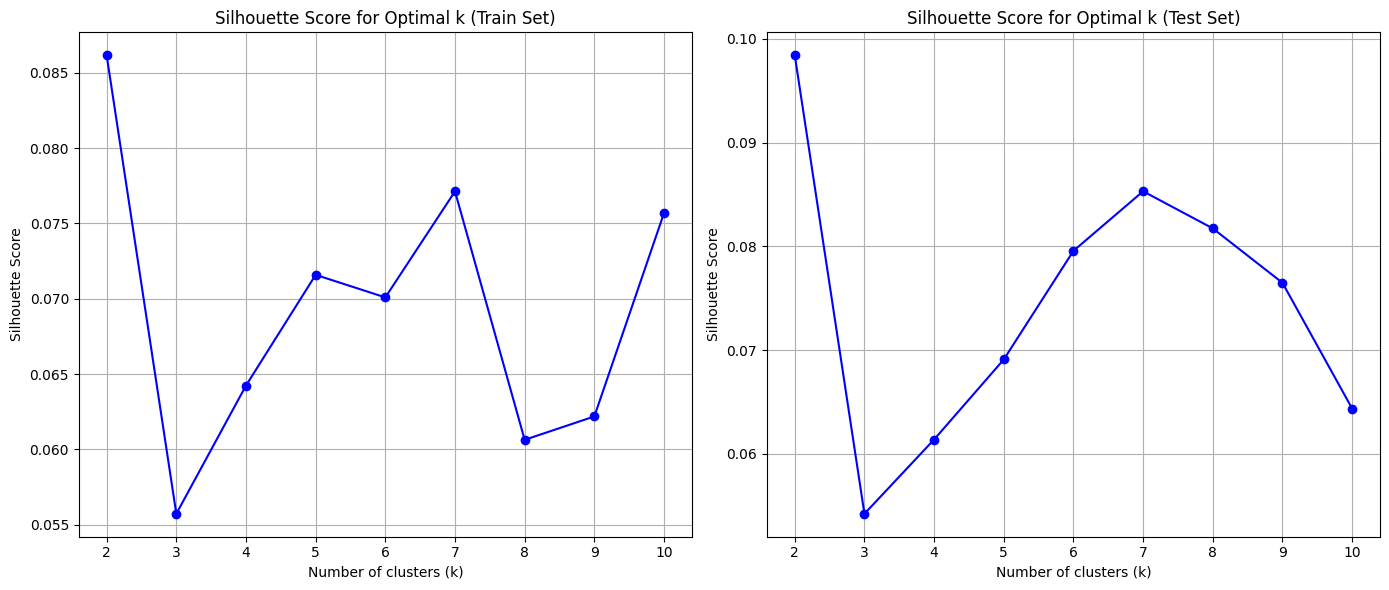

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting train silhouette scores
axs[0].plot(K, silhouette_scores_train, 'bx-', marker='o')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Score for Optimal k (Train Set)')
axs[0].grid(True)

# Plotting test silhouette scores
axs[1].plot(K, silhouette_scores_test, 'bx-', marker='o')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score for Optimal k (Test Set)')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Question 05

Please implement kernel k-means algorithm with RBF-kernel, that is, 

$$k(\mathbf{x}_i,\mathbf{x}_j) = \exp(\frac{-\|\mathbf{x}_i - \mathbf{x}_j\|_2^2}{2\sigma^2})$$

where the hyper-parameter can be empirically set to,

$$2\sigma^2 = \frac{1}{N^2} \sum_{i=1}^{N}\sum_{j=1}^{N} \| \mathbf{x}_i -\mathbf{x}_j\|_2^2$$

Please only use the first 500 samples and cluster the them into 5 groups. This is for reducing the running time of your code.

**Tips**: If you can use matrix operations to replace summations, your code will be more efficient. However, this is just optional.